# **(ADD THE NOTEBOOK NAME HERE)**

## Objectives

* Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write down which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

Hypotheses that will be tested in this notebook:
| # | Hypothesis | Validation Approach |
|---|------------|-------------------|
| 1 | Higher humidity reduces solar power output. | Analyze correlation between `humidity` and `poly_pwr` |
| 2 | Cloud ceiling negatively correlates with photovoltaic power output. | Scatter plots of `cloud_ceiling` vs `poly_pwr`; compute correlation coefficients; test with regression models. |
| 3 | Solar power output is higher in summer and at midday. | Plot `poly_pwr` by `month` and `hour`; use boxplots and line charts to highlight seasonal and daily patterns. |
| 4 | Altitude affects efficiency. | Compare `poly_pwr` across sites with different `altitude`; use scatter plots and regression analysis. |
| 5 | Location matters — some sites consistently produce more energy. | Aggregate `poly_pwr` by `location`; visualize using bar charts or maps to compare average performance across sites. |



---

In [1]:
import pandas as pd # data manipulation and analysis
import numpy as np # numerical operations
import plotly.express as px # interactive visualizations
import plotly.graph_objects as go # more complex visualizationss
import seaborn as sns # statistical data visualization
import matplotlib.pyplot as plt # plotting library
from scipy.stats import f_oneway, kruskal # statistical tests
import statsmodels.api as sm # statistical models
from statsmodels.formula.api import ols # ordinary least squares regression
from scipy import stats # scientific computations
import plotly.io as pio # plotly input/output
import os # operating system interface


In [2]:
df = pd.read_csv('../data/clean/photovoltaic_cleaned.csv') 

In [3]:
df.head(5)  # Display the first 5 rows of the dataframe

,location,date,time,latitude,longitude,altitude,month,hour,season,humidity,ambient_temp,poly_pwr,wind_speed,visibility,pressure,cloud_ceiling,datetime
0,camp_murray,20171203,1145,47.11,-122.57,84,12,11,winter,81.71997,12.86919,2.42769,5,10.0,1010.6,722,2017-12-03 11:45:00
1,camp_murray,20171203,1315,47.11,-122.57,84,12,13,winter,96.64917,9.66415,2.46273,0,10.0,1011.3,23,2017-12-03 13:15:00
2,camp_murray,20171203,1330,47.11,-122.57,84,12,13,winter,93.61572,15.44983,4.46836,5,10.0,1011.6,32,2017-12-03 13:30:00
3,camp_murray,20171204,1230,47.11,-122.57,84,12,12,winter,77.21558,10.36659,1.65364,5,2.0,1024.4,6,2017-12-04 12:30:00
4,camp_murray,20171204,1415,47.11,-122.57,84,12,14,winter,54.80347,16.85471,6.57939,3,3.0,1023.7,9,2017-12-04 14:15:00


In [4]:
df.dtypes

location          object
date               int64
time               int64
latitude         float64
longitude        float64
altitude           int64
month              int64
hour               int64
season            object
humidity         float64
ambient_temp     float64
poly_pwr         float64
wind_speed         int64
visibility       float64
pressure         float64
cloud_ceiling      int64
datetime          object
dtype: object

In [5]:
df['location'] = df['location'].astype('category')
df['season'] = df['season'].astype('category')
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df.dtypes



location               category
date                      int64
time                      int64
latitude                float64
longitude               float64
altitude                  int64
month                     int64
hour                      int64
season                 category
humidity                float64
ambient_temp            float64
poly_pwr                float64
wind_speed                int64
visibility              float64
pressure                float64
cloud_ceiling             int64
datetime         datetime64[ns]
dtype: object

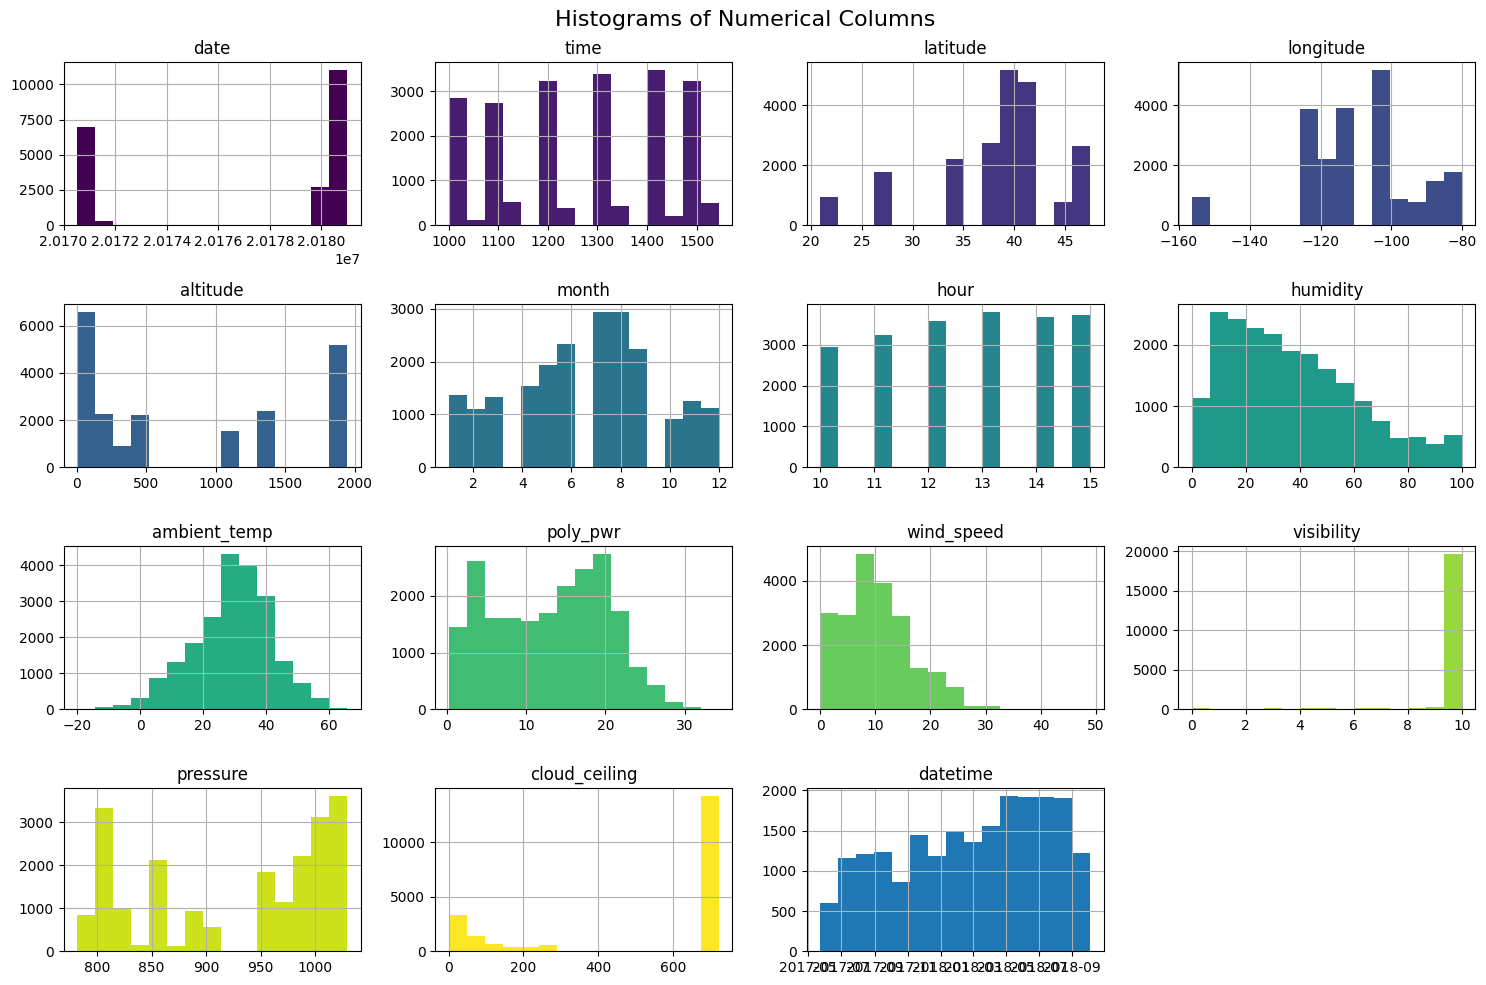

In [6]:
# histogram figure with charts for all numerical columns, every chart  different bar color
import matplotlib.pyplot as plt
numerical_cols = df.select_dtypes(include=['float64', 'int64'])
colors = plt.cm.viridis(np.linspace(0, 1, len(numerical_cols.columns)))
axes = df.hist(bins=15, figsize=(15, 10))
for i, ax in enumerate(axes.flatten()[:len(numerical_cols.columns)]):
	for patch in ax.patches:
		patch.set_facecolor(colors[i])
plt.suptitle('Histograms of Numerical Columns', fontsize=16)
plt.tight_layout()
plt.show() 

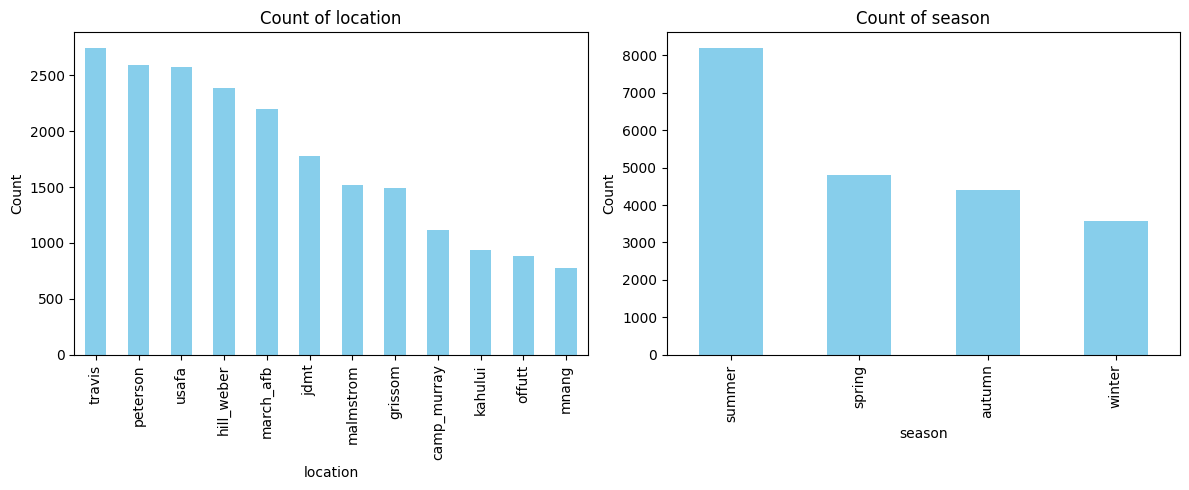

In [7]:
#Bar charts of counts for categorical columns, two charts on one figure
categorical_cols = df.select_dtypes(include=['category'])
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for i, col in enumerate(categorical_cols.columns[:2]):  # Limit to first two
    df[col].value_counts().plot(kind='bar', ax=axes[i], color='skyblue')
    axes[i].set_title(f'Count of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()


Weather vs power

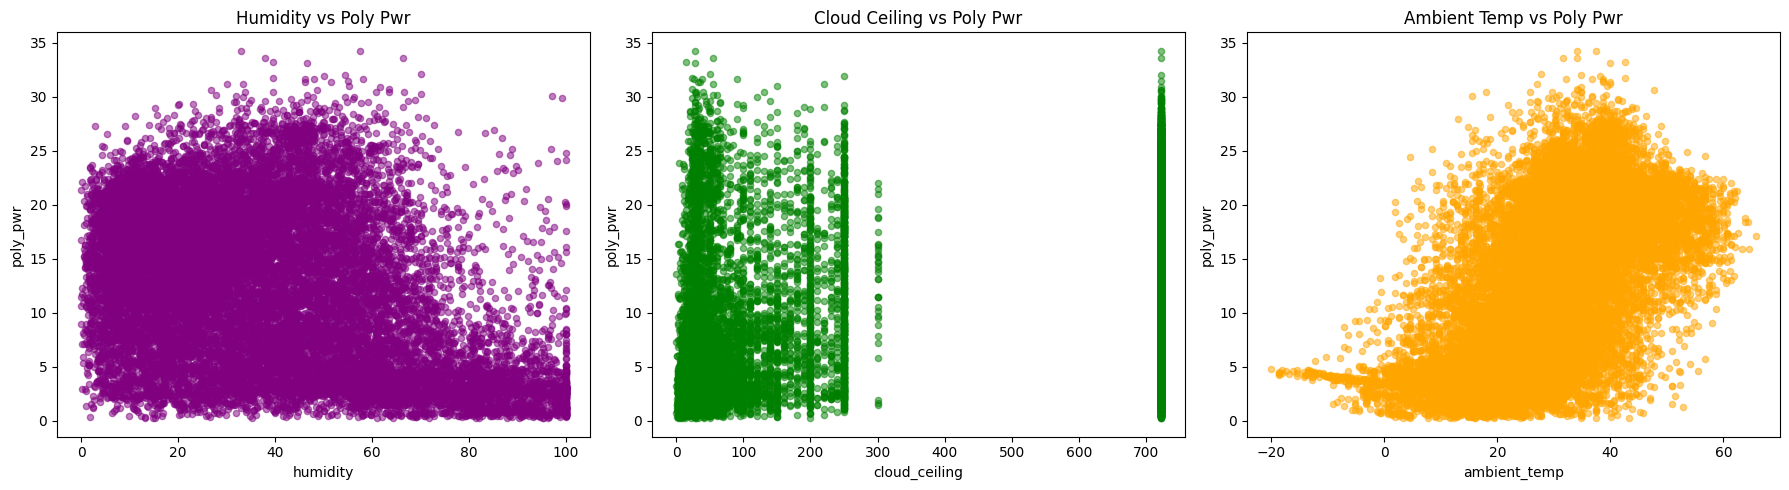

In [8]:
# humidity vs poly_pwr, cloud_ceiling vs poly_pwr, ambient_temp vs poly_pwr
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df.plot.scatter(x='humidity', y='poly_pwr', ax=axes[0],
                color='purple', alpha=0.5)
axes[0].set_title('Humidity vs Poly Pwr')
df.plot.scatter(x='cloud_ceiling', y='poly_pwr', ax=axes[1],
                color='green', alpha=0.5)
axes[1].set_title('Cloud Ceiling vs Poly Pwr')

df.plot.scatter(x='ambient_temp', y='poly_pwr', ax=axes[2],
                color='orange', alpha=0.5)
axes[2].set_title('Ambient Temp vs Poly Pwr')
plt.tight_layout()  
plt.show()

**Hypothesis 1: "Higher humidity reduces solar power output"**

Validation: 
- Analise correlation between humidity and poly_pwr
- plot scatter plot with trend line to visualize relationship

Correlation between Humidity and Poly Pwr: -0.40


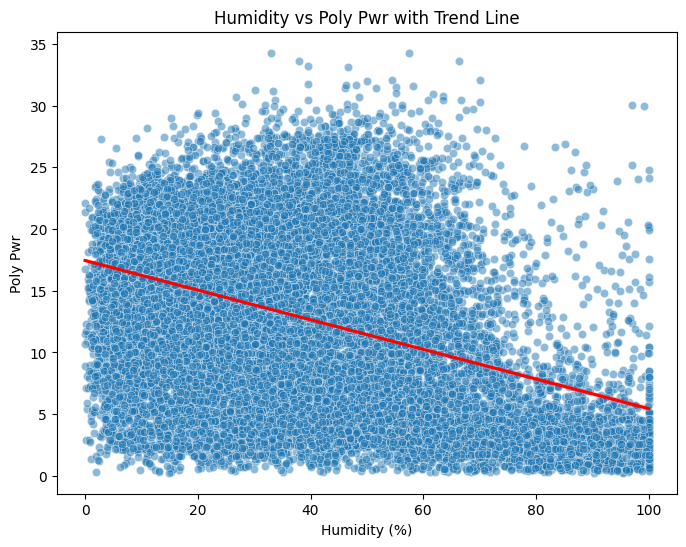

In [9]:
# analyse correlation between humidity and poly_pwr
correlation = df['humidity'].corr(df['poly_pwr'])
print(f'Correlation between Humidity and Poly Pwr: {correlation:.2f}')  

plt.figure(figsize=(8, 6))
sns.scatterplot(x='humidity', y='poly_pwr', data=df, alpha=0.5)
sns.regplot(x='humidity', y='poly_pwr', data=df, scatter=False, color='red')
plt.title('Humidity vs Poly Pwr with Trend Line')       
plt.xlabel('Humidity (%)')
plt.ylabel('Poly Pwr')
plt.show()  

A correlation of -0.40 between humidity and poly_pwr means moderate negative relationship: as humidity increases, photovoltaic power output tends to decrease, but it’s not a perfect relationship
- Negative, meaning higher humidity generally corresponds to lower solar power output.
- Moderate strenghth (correlations around ±0.3–0.5 are usually considered moderate). It suggests humidity is an important factor, but not the only one affecting solar output.
- Implication: Days with high humidity (foggy or rainy conditions) likely reduce PV efficiency, which aligns with solar physics since water vapor and clouds block sunlight.

Conclusion: **Hypothesis 1 is supported** - as humidity increases, solar power output tends to decrease

**Hypothesis 2: "Higher cloud ceiling negatively correlates with photovoltaic power output"**

Validation:
- Analyze correlation between cloud ceiling and poly_pwr
- Plot scatter plot with trend line to visualize relationship

Correlation between Cloud Ceiling and Poly Pwr: 0.42


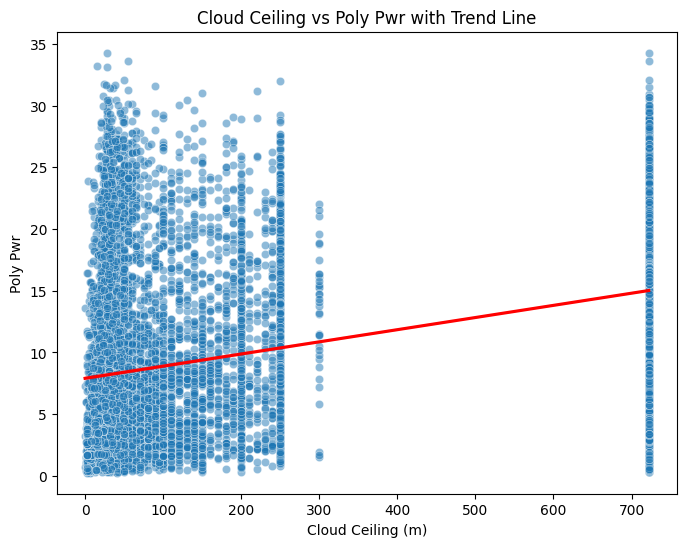

In [10]:
# analyse correlation between cloud ceiling and poly_pwr
correlation = df['cloud_ceiling'].corr(df['poly_pwr'])
print(f'Correlation between Cloud Ceiling and Poly Pwr: {correlation:.2f}')  

plt.figure(figsize=(8, 6))
sns.scatterplot(x='cloud_ceiling', y='poly_pwr', data=df, alpha=0.5)
sns.regplot(x='cloud_ceiling', y='poly_pwr', data=df, scatter=False, color='red')
plt.title('Cloud Ceiling vs Poly Pwr with Trend Line')       
plt.xlabel('Cloud Ceiling (m)') 
plt.ylabel('Poly Pwr')
plt.show()  

The **Hypothesis 2 is not supported** by the data — in fact, the trend is the opposite: higher cloud ceilings tend to be associated with higher photovoltaic power output.
Cloud ceiling has a moderate positive correlation with photovoltaic power output—higher cloud ceilings generally correspond to higher poly_pwr.
Conclusion: more open skies and less low cloud cover allow more sunlight to reach the panels, boosting efficiency.

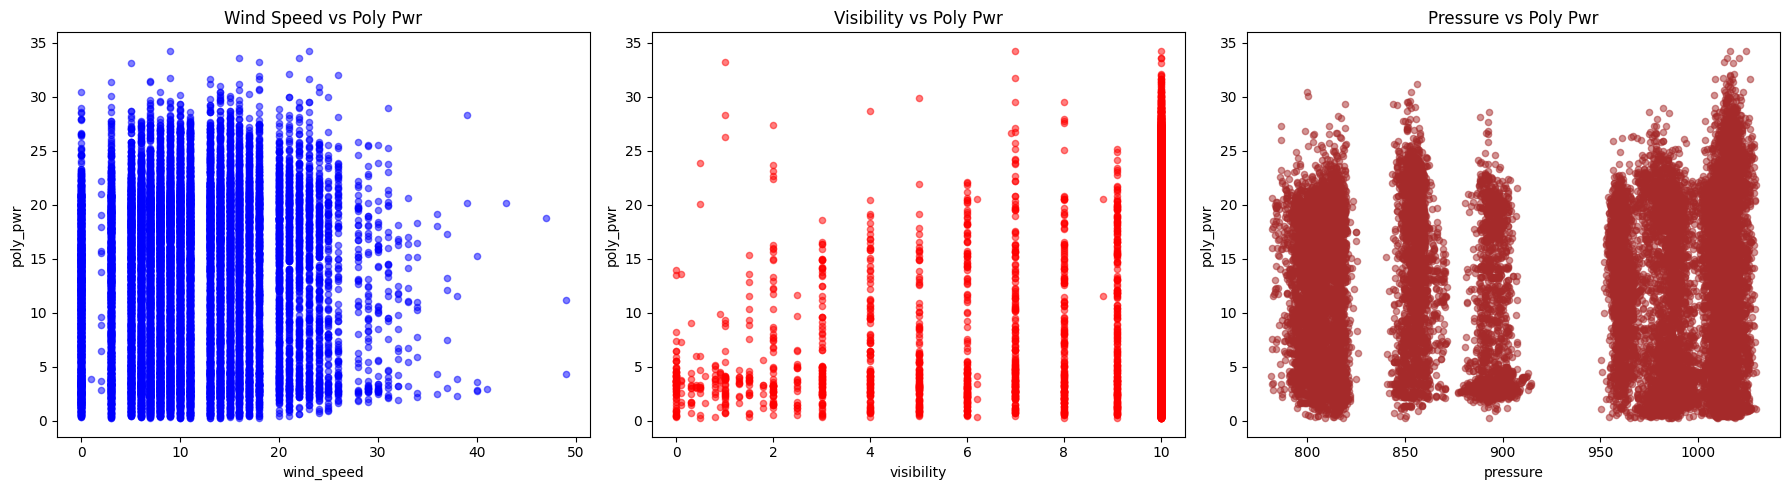

In [11]:
# Wind speed, visibility, and pressure vs poly_pwr 
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
df.plot.scatter(x='wind_speed', y='poly_pwr', ax=axes[0],
                color='blue', alpha=0.5)    
axes[0].set_title('Wind Speed vs Poly Pwr')
df.plot.scatter(x='visibility', y='poly_pwr', ax=axes[1],
                color='red', alpha=0.5)
axes[1].set_title('Visibility vs Poly Pwr') 
df.plot.scatter(x='pressure', y='poly_pwr', ax=axes[2],
                color='brown', alpha=0.5)
axes[2].set_title('Pressure vs Poly Pwr')
plt.tight_layout()  
plt.show()


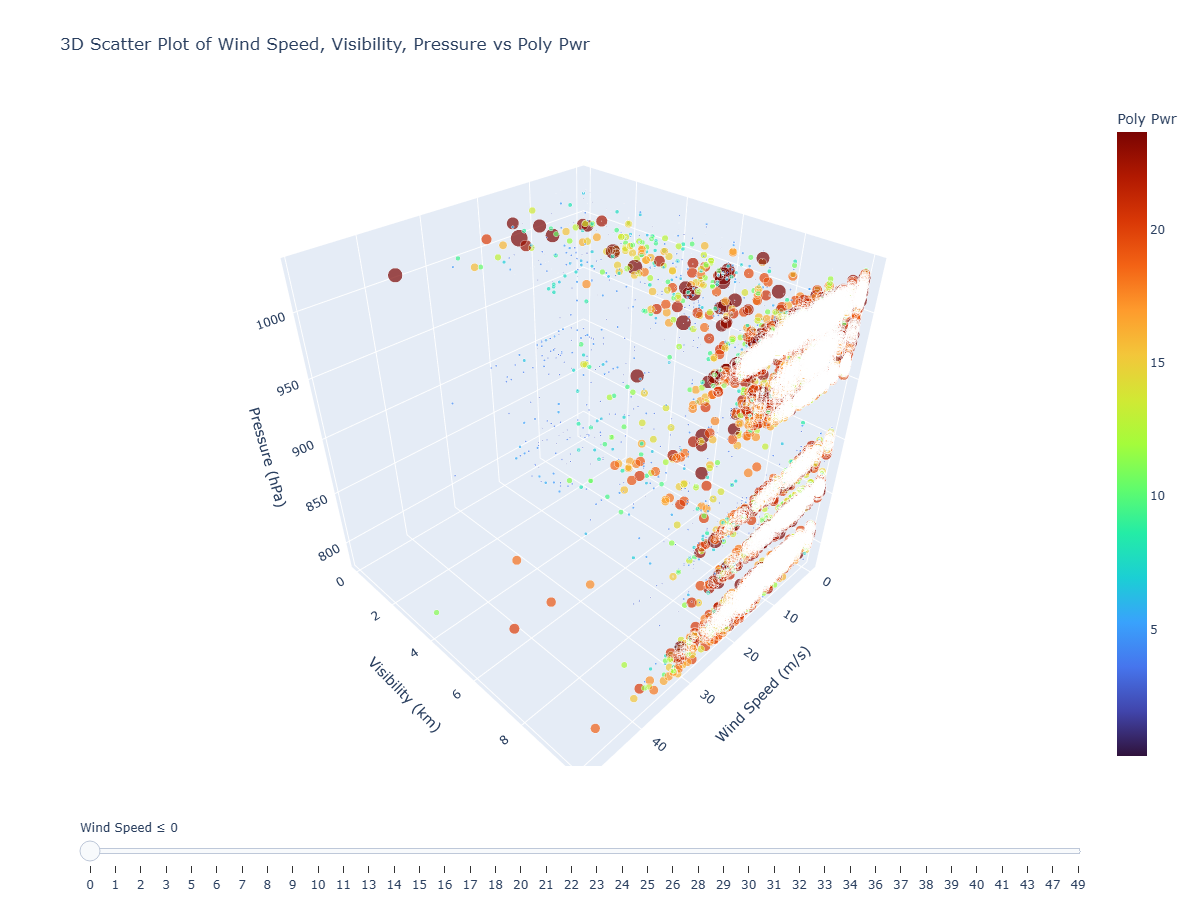

In [12]:
# 3D scatter plot: wind_speed, visibility, pressure vs poly_pwr
poly_pwr_max = df['poly_pwr'].quantile(0.95)  # top 5% threshold, cap color scale

# Base 3D scatter
scatter = go.Scatter3d(
    x=df['wind_speed'],
    y=df['visibility'],
    z=df['pressure'],
    mode='markers',
    marker=dict(
        size=df['poly_pwr'] / df['poly_pwr'].max() * 20,  # scale size
        color=df['poly_pwr'],
        colorscale='Turbo',
        cmin=df['poly_pwr'].min(),
        cmax=poly_pwr_max,
        colorbar=dict(title='Poly Pwr')
    ),
    text=df['location'],  # hover text
    hovertemplate=(
        'Location: %{text}<br>'
        'Wind Speed: %{x} m/s<br>'
        'Visibility: %{y} km<br>'
        'Pressure: %{z} hPa<br>'
        'Poly Pwr: %{marker.color}<extra></extra>'
    )
)

# Assign to fig_cell12 
fig_cell12 = go.Figure(scatter)

# Layout settings
fig_cell12.update_layout(
    title='3D Scatter Plot of Wind Speed, Visibility, Pressure vs Poly Pwr',
    width=1200,
    height=900,
    scene=dict(
        xaxis=dict(title='Wind Speed (m/s)'),
        yaxis=dict(title='Visibility (km)'),
        zaxis=dict(title='Pressure (hPa)')
    )
)

# Add wind speed slider
fig_cell12.update_layout(
    sliders=[{
        'active': 0,
        'currentvalue': {"prefix": "Wind Speed ≤ "},
        'pad': {"t": 50},
        'steps': [
            {
                'label': f"{round(ws, 1)}",
                'method': 'update',
                'args': [
                    {'x': [df[df['wind_speed'] <= ws]['wind_speed']],
                     'y': [df[df['wind_speed'] <= ws]['visibility']],
                     'z': [df[df['wind_speed'] <= ws]['pressure']],
                     'marker.color': [df[df['wind_speed'] <= ws]['poly_pwr']],
                     'text': [df[df['wind_speed'] <= ws]['location']]
                    },
                    {}
                ]
            } for ws in sorted(df['wind_speed'].unique())
        ]
    }]
)


# Make sure the folder exists
os.makedirs("plots", exist_ok=True)

# Save interactive HTML
pio.write_html(fig_cell12, file="plots/chart_12.html", auto_open=False)

# Show a static preview in the notebook
pio.renderers.default = "png"
fig_cell12.show()


[View interactive chart 12](plots/chart_12.html)

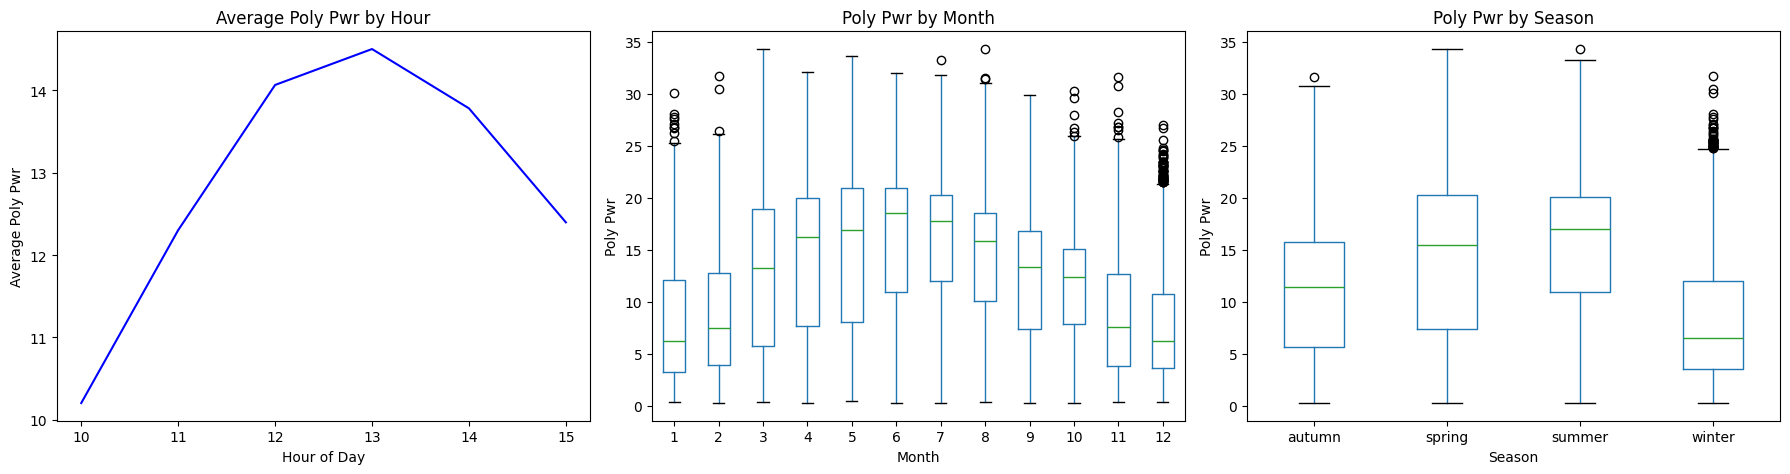

In [13]:
# Line plots of average poly_pwr by hour (daily pattern), Boxplots by month (seasonal variation), Boxplots by season to compare seasonal effects, all these on one figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Daily pattern
# Use existing 'hour' column instead of extracting from timestamp
daily_avg = df.groupby('hour')['poly_pwr'].mean()
daily_avg.plot(ax=axes[0], color='blue')    
axes[0].set_title('Average Poly Pwr by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Poly Pwr')

# Seasonal variation by month
# Use existing 'month' column instead of extracting from timestamp
df.boxplot(column='poly_pwr', by='month', ax=axes[1], grid=False)
axes[1].set_title('Poly Pwr by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Poly Pwr')
plt.suptitle('')  # Remove automatic title
# Seasonal effects by season
df.boxplot(column='poly_pwr', by='season', ax=axes[2],
              grid=False)
axes[2].set_title('Poly Pwr by Season')
axes[2].set_xlabel('Season')
axes[2].set_ylabel('Poly Pwr')  
plt.suptitle('')  # Remove automatic title
plt.tight_layout()  
plt.show()


**Hypothesis 3: "Solar power output is higher in summer and at midday."**

Validation:
- Line plots of hourly averages per month – show how solar output varies during the day for each month and across months for each hour.
- Heatmap of hourly vs monthly averages – gives a compact overview of output intensity by time of day and month, showing both summer and midday patterns in one plot.
- Combination of ANOVA, non-parametric tests, and top-output analysis

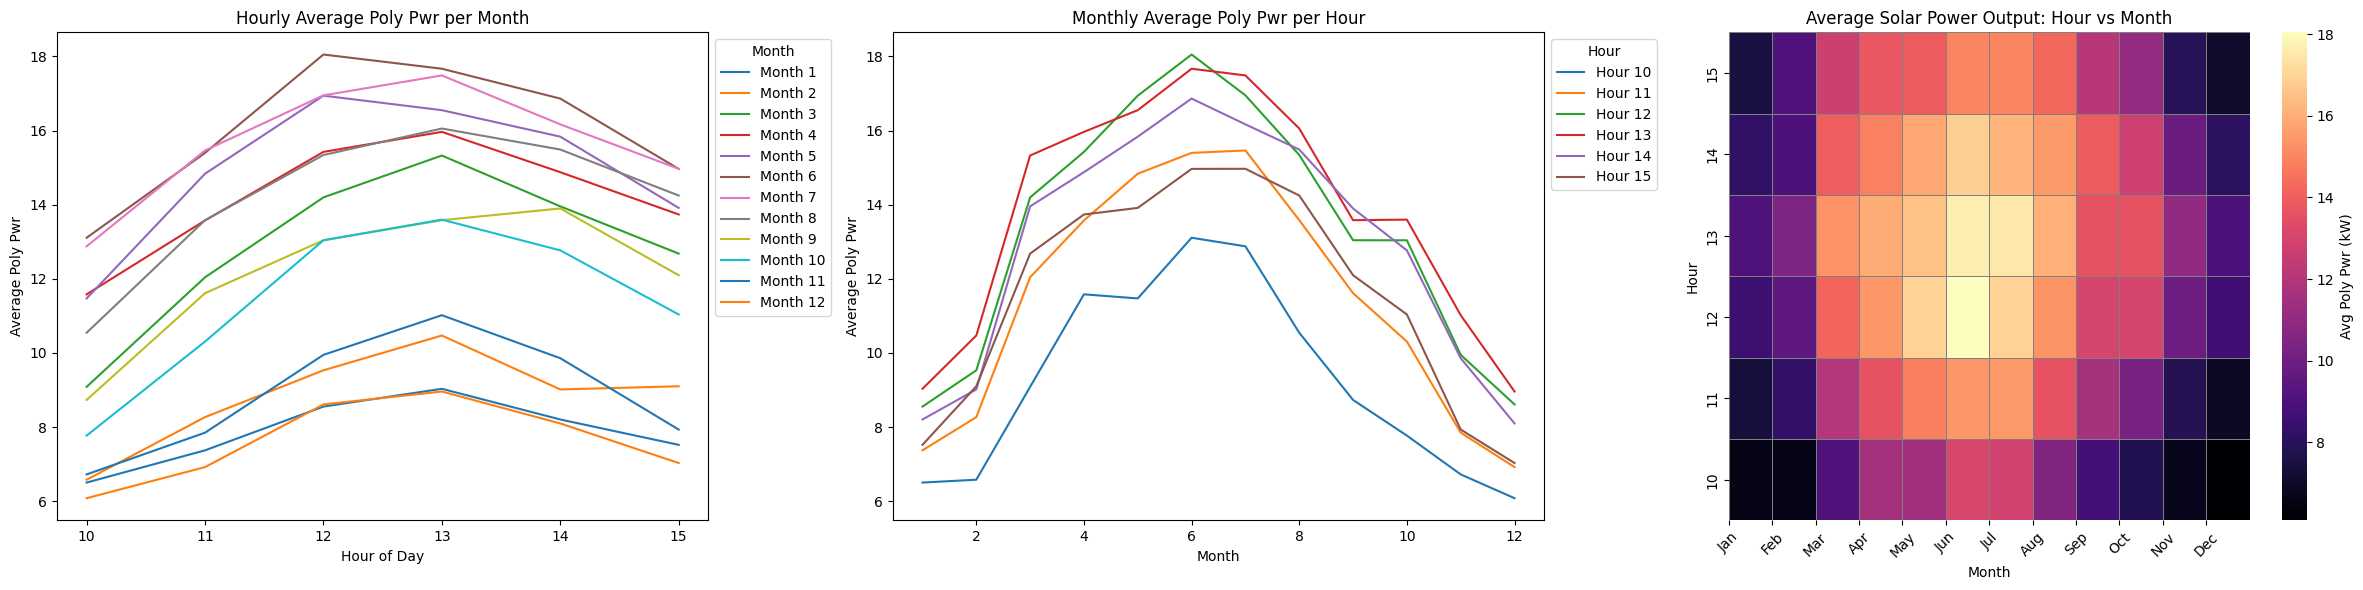

In [14]:
# Create pivot table: hours vs months
hour_month_avg = df.pivot_table(index='hour', columns='month', values='poly_pwr', aggfunc='mean')

# Create figure with 3 subplots: 2 line plots + 1 heatmap
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# --- Subplot 1: Hourly averages per month ---
for month in sorted(df['month'].unique()):
    monthly_data = df[df['month'] == month]
    hourly_avg = monthly_data.groupby('hour')['poly_pwr'].mean()
    axes[0].plot(hourly_avg.index, hourly_avg.values, label=f'Month {month}')

axes[0].set_title('Hourly Average Poly Pwr per Month')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Poly Pwr')
axes[0].legend(title='Month', loc='upper left', bbox_to_anchor=(1, 1))  # legend outside plot

# --- Subplot 2: Monthly averages per hour ---
for hour in sorted(df['hour'].unique()):
    hourly_data = df[df['hour'] == hour]
    monthly_avg = hourly_data.groupby('month')['poly_pwr'].mean()
    axes[1].plot(monthly_avg.index, monthly_avg.values, label=f'Hour {hour}')

axes[1].set_title('Monthly Average Poly Pwr per Hour')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Poly Pwr')
axes[1].legend(title='Hour', loc='upper left', bbox_to_anchor=(1, 1))  # legend outside plot

# --- Subplot 3: Heatmap of hour vs month ---
sns.heatmap(hour_month_avg, cmap='magma', cbar_kws={'label': 'Avg Poly Pwr (kW)'},
            linewidths=0.5, linecolor='gray', ax=axes[2])
axes[2].set_title('Average Solar Power Output: Hour vs Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Hour')
axes[2].set_xticks(range(12))
axes[2].set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], rotation=45)
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()


In [15]:
# -------------------------------
# 1. One-way ANOVA: Month effect
# -------------------------------
month_groups = [df[df['month'] == m]['poly_pwr'] for m in sorted(df['month'].unique())]
f_stat_month, p_val_month = f_oneway(*month_groups)
print("One-way ANOVA: Month effect")
print(f"F-statistic: {f_stat_month:.2f}, p-value: {p_val_month:.4f}\n")

# Non-parametric alternative: Kruskal-Wallis
stat_month, p_val_kruskal_month = kruskal(*month_groups)
print("Kruskal-Wallis test (month effect)")
print(f"Statistic: {stat_month:.2f}, p-value: {p_val_kruskal_month:.4f}\n")

# -------------------------------
# 2. One-way ANOVA: Hour effect
# -------------------------------
hour_groups = [df[df['hour'] == h]['poly_pwr'] for h in sorted(df['hour'].unique())]
f_stat_hour, p_val_hour = f_oneway(*hour_groups)
print("One-way ANOVA: Hour effect")
print(f"F-statistic: {f_stat_hour:.2f}, p-value: {p_val_hour:.4f}\n")

# Non-parametric alternative: Kruskal-Wallis
stat_hour, p_val_kruskal_hour = kruskal(*hour_groups)
print("Kruskal-Wallis test (hour effect)")
print(f"Statistic: {stat_hour:.2f}, p-value: {p_val_kruskal_hour:.4f}\n")

# -------------------------------
# 3. Two-way ANOVA: Month × Hour interaction
# -------------------------------
# Make sure month and hour are categorical for ANOVA
df['month_cat'] = df['month'].astype('category')
df['hour_cat'] = df['hour'].astype('category')

model = ols('poly_pwr ~ C(month_cat) + C(hour_cat) + C(month_cat):C(hour_cat)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("Two-way ANOVA: Month × Hour interaction")
print(anova_table, "\n")

# -------------------------------
# 4. Top-output analysis: Which months and hours produce the highest output
# -------------------------------
top_10pct = df[df['poly_pwr'] >= df['poly_pwr'].quantile(0.9)]
top_summary = top_10pct.groupby(['month', 'hour'])['poly_pwr'].count().unstack(fill_value=0)
print("Top 10% poly_pwr occurrence by month and hour:")
print(top_summary)


One-way ANOVA: Month effect
F-statistic: 347.00, p-value: 0.0000

Kruskal-Wallis test (month effect)
Statistic: 3325.35, p-value: 0.0000

One-way ANOVA: Hour effect
F-statistic: 167.65, p-value: 0.0000

Kruskal-Wallis test (hour effect)
Statistic: 882.03, p-value: 0.0000

Two-way ANOVA: Month × Hour interaction
                                 sum_sq       df           F         PR(>F)
C(month_cat)              171608.902573     11.0  384.116032   0.000000e+00
C(hour_cat)                48446.581255      5.0  238.565938  1.258874e-248
C(month_cat):C(hour_cat)    3925.861448     55.0    1.757469   4.553188e-04
Residual                  849702.965960  20921.0         NaN            NaN 

Top 10% poly_pwr occurrence by month and hour:
hour   10  11  12   13   14  15
month                          
1       0   6  11   16    4   2
2       0   9  19   17    8  17
3       5  32  36   55   35  32
4      10  25  28   52   33  26
5       8  41  83  106   87  42
6       2  39  89  156  113  50
7 

- One-way ANOVA (Month effect):
F = 347, p < 0.0001 → The mean solar power output significantly differs across months.
Kruskal-Wallis test also confirms this with p < 0.0001, indicating the result is robust even if normality assumptions are violated.
Implication: **Solar output is indeed higher in some months (summer)** and lower in others (winter).

- One-way ANOVA (Hour effect):
F = 167.65, p < 0.0001 → Mean output differs significantly across hours of the day.
Kruskal-Wallis test confirms non-parametrically that **midday hours have higher output** than early morning or late afternoon.

- Two-way ANOVA (Month × Hour interaction):
Both month and hour have strong main effects on output.
The interaction term is significant (p = 0.000455), showing that **the effect of hour depends on the month** — i.e., the midday peak is more pronounced in summer months than in winter.

- Top 10% Output Analysis:
High-output hours are concentrated around 11:00–14:00, especially in May, June, and July.
This aligns visually with your heatmap and line plots, confirming that **summer months and midday hours contribute most to high solar power output**.

The visualisations, the combination of ANOVA, non-parametric tests, and top-output analysis provides **strong evidence supporting Hypothesis 3: solar power output is higher in summer and at midday.**

**Hypothesis 4: Altitude affects efficiency.** 

Validation:
- Scatter plot of poly_pwr vs altitude, colored by location
- Bar plot of average poly_pwr by altitude
- Kruskal-Wallis test to compare medians across groups

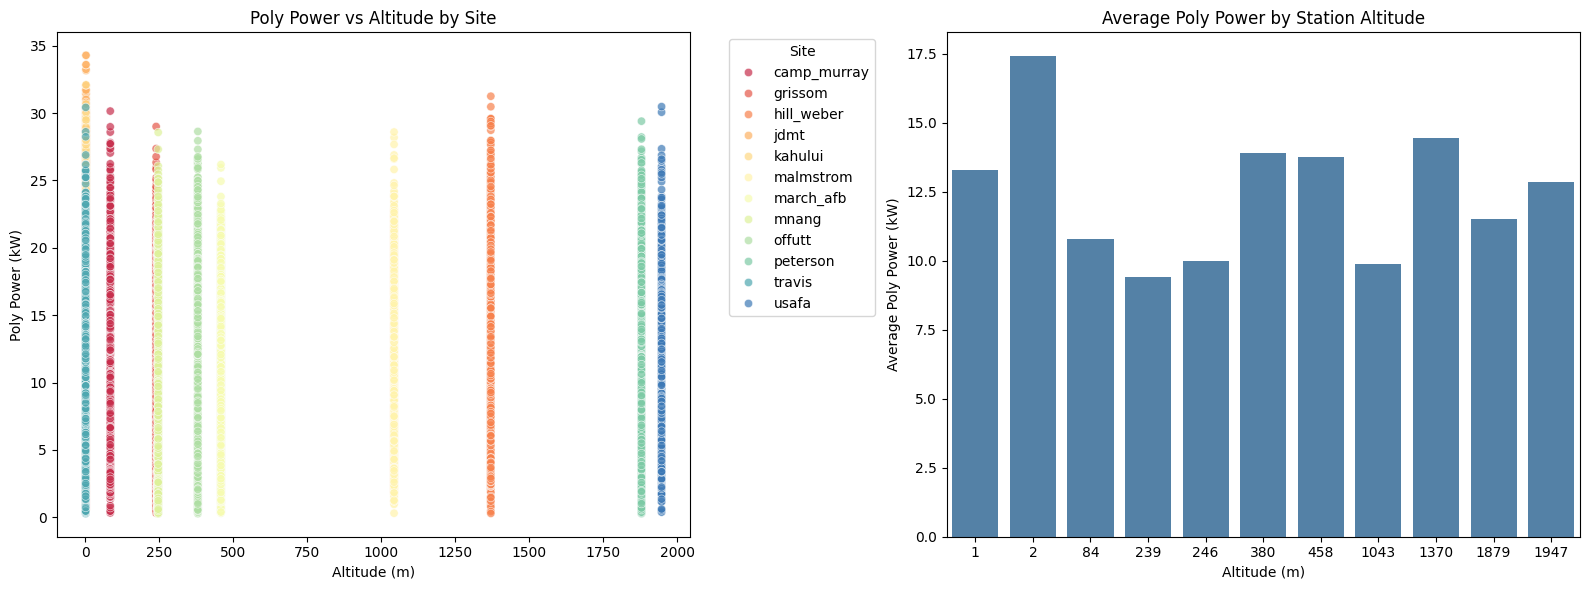

In [16]:
# Compute average poly power per altitude
avg_power = df.groupby('altitude')['poly_pwr'].mean().reset_index()

# Create a figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Poly Power vs Altitude by Site
sns.scatterplot(
    x='altitude', y='poly_pwr', hue='location', data=df,
    palette='Spectral', alpha=0.7, ax=axes[0]
)
axes[0].set_title('Poly Power vs Altitude by Site')
axes[0].set_xlabel('Altitude (m)')
axes[0].set_ylabel('Poly Power (kW)')
axes[0].legend(title='Site', bbox_to_anchor=(1.05, 1), loc='upper left')

# Bar plot: Average Poly Power by Station Altitude
sns.barplot(
    x='altitude', y='poly_pwr', data=avg_power, color='steelblue', ax=axes[1]
)
axes[1].set_title('Average Poly Power by Station Altitude')
axes[1].set_xlabel('Altitude (m)')
axes[1].set_ylabel('Average Poly Power (kW)')

plt.tight_layout()
plt.show()



Scatter plot analysis:
- The vertical clustering confirms each station operates independently with its own local conditions.
- The lack of clear altitude trend implies solar irradiance and weather dominate over elevation in determining PV performance.
- Most sites, regardless of altitude, show similar power ranges (typically 0–30 kW). This implies that altitude alone does not strongly determine poly power — other variables (irradiance, humidity, cloud cover) likely have stronger influence.
- Even though air pressure and temperature decrease with elevation, power output doesn’t seem to drop dramatically. This suggests PV performance remains robust across moderate altitude differences

Bar plot analysis:
- The bar chart illustrates the average photovoltaic (poly) power output (kW) at different station altitudes (m). While lower-altitude sites (near sea level) show slightly higher average power outputs, the overall variation across elevations is modest. This indicates that altitude alone has a limited direct effect on PV performance. 
- Differences among stations are likely driven by local climate conditions—such as solar irradiance, humidity, and cloud cover—rather than elevation itself.

In [17]:
# Create altitude bins
df['altitude_bin'] = pd.cut(df['altitude'], bins=[0, 750, 1500, 2000], labels=['0-750', '751-1500', '1501-2000'])

# Prepare data for Kruskal-Wallis test
groups = [group['poly_pwr'].values for name, group in df.groupby('altitude_bin', observed=True)]

# Perform Kruskal-Wallis test
kw_stat, kw_p = stats.kruskal(*groups)

print("Average Poly Power per Altitude Bin:")
print(df.groupby('altitude_bin', observed=True)['poly_pwr'].mean().reset_index())
print(f"\nKruskal-Wallis test: Statistic={kw_stat:.2f}, p-value={kw_p:.4f}")


Average Poly Power per Altitude Bin:
  altitude_bin   poly_pwr
0        0-750  13.432861
1     751-1500  12.667333
2    1501-2000  12.186679

Kruskal-Wallis test: Statistic=110.44, p-value=0.0000


While there is a statistically significant difference in PV output across altitude bins, the effect size is modest. This aligns with the earlier observation that local climate and irradiance dominate PV performance, rather than altitude itself. In practical terms, PV efficiency remains relatively robust across the observed elevation range.

**Hypothesis 4 - "Altitude affects efficiency"** is only **partially validated**. While the Kruskal-Wallis test shows statistically significant differences in PV power across altitude bins, the actual differences in average output are small, and the scatter and bar plots indicate that most variation is driven by local weather conditions rather than elevation. This suggests that altitude has a limited direct effect on PV performance, making the hypothesis only partially supported.

**Hypothesis 5: "Location matters — some sites consistently produce more energy."**

Pie chart of total poly_pwr by location to show distribution of energy production across sites.

C:\Users\vkbg1\AppData\Local\Temp\ipykernel_89732\702733136.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



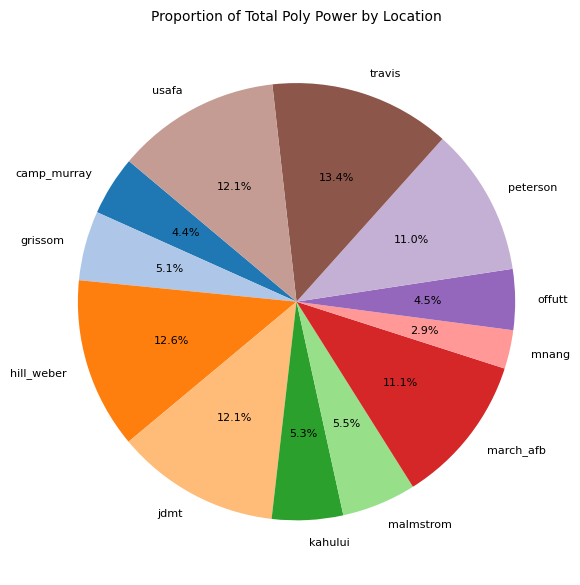

In [18]:
# Sum of poly_pwr per location
total_power = df.groupby('location')['poly_pwr'].sum()

plt.figure(figsize=(6, 6))  # smaller figure
plt.pie(
    total_power,
    labels=total_power.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.tab20.colors,
    textprops={'fontsize': 8}  # smaller font
)
plt.title('Proportion of Total Poly Power by Location', fontsize=10)
plt.tight_layout()
plt.show()

C:\Users\vkbg1\AppData\Local\Temp\ipykernel_89732\2377937330.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



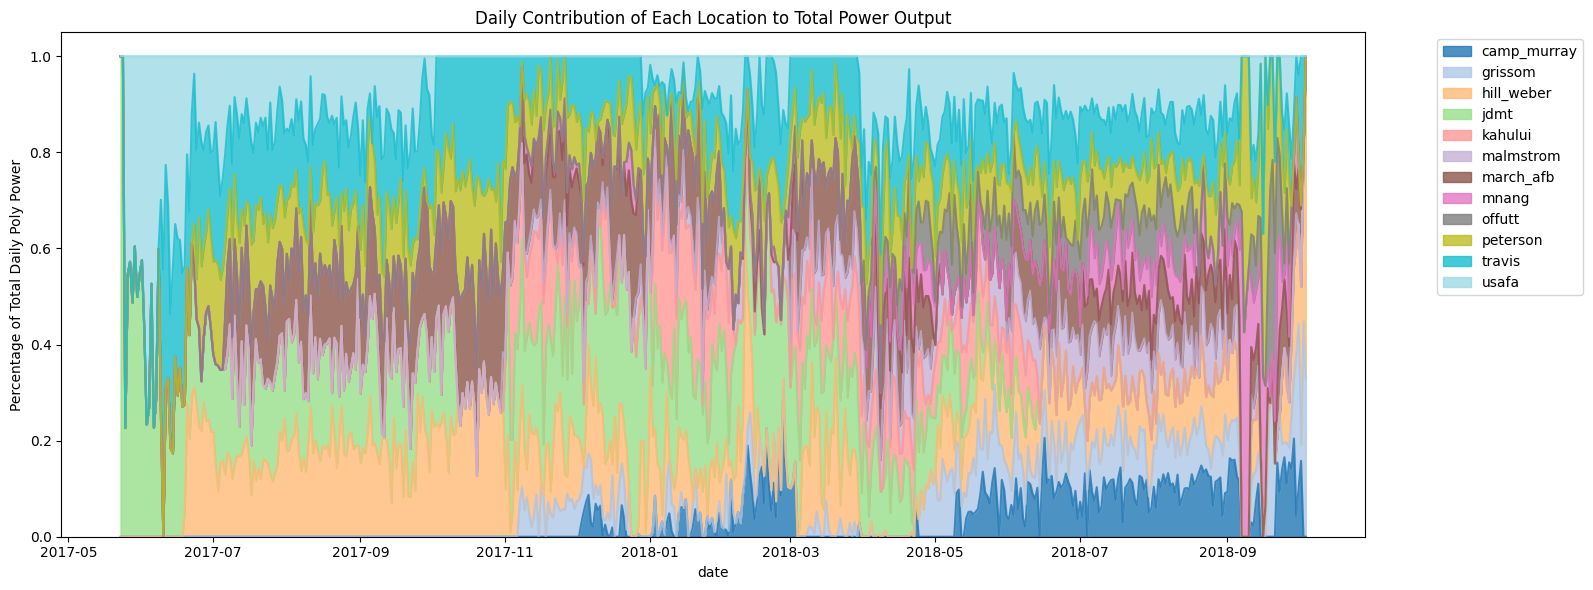

In [19]:

# Ensure folder exists
os.makedirs("plots", exist_ok=True)

# Your original plotting code
df['date'] = pd.to_datetime(df['datetime']).dt.date
daily_totals = df.groupby(['date','location'])['poly_pwr'].sum().unstack(fill_value=0)
daily_percent = daily_totals.div(daily_totals.sum(axis=1), axis=0)

# Plot
fig_cell19, ax = plt.subplots(figsize=(16,6))
daily_percent.plot(kind='area', ax=ax, cmap='tab20', alpha=0.8)
ax.set_ylabel('Percentage of Total Daily Poly Power')
ax.set_title('Daily Contribution of Each Location to Total Power Output')
ax.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()

# Save static PNG
fig_cell19.savefig("plots/chart_19.png", dpi=150)

# Show plot in notebook
plt.show()


In [20]:
#Compute mean, median, standard deviation, and 10th/90th percentiles of poly_pwr by location.
location_stats = df.groupby('location')['poly_pwr'].agg(['mean', 'median', 'std', lambda x: x.quantile(0.1), lambda x: x.quantile(0.9)])
location_stats.columns = ['mean', 'median', 'std', '10th_percentile', '90th_percentile']
print(location_stats)   

                  mean     median       std  10th_percentile  90th_percentile
location                                                                     
camp_murray  10.777723   9.777130  6.880721         2.462730        20.048794
grissom       9.426174   6.580520  6.762727         2.744970        19.944984
hill_weber   14.437151  15.298295  6.818257         4.152880        22.469701
jdmt         18.574124  20.735580  7.478708         7.378068        26.986648
kahului      15.222645  16.177870  7.203831         4.398680        24.187170
malmstrom     9.886024   7.474110  7.074350         2.744190        20.243244
march_afb    13.764184  14.555110  5.117353         5.939130        19.824840
mnang         9.996263   7.638825  7.714226         1.337212        20.640987
offutt       13.895667  16.523760  8.108225         1.636630        22.775590
peterson     11.532440  11.385880  6.809252         2.569160        20.506720
travis       13.296735  14.593975  6.672362         2.364105    

C:\Users\vkbg1\AppData\Local\Temp\ipykernel_89732\679569348.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



There is clear variability across locations. For example, jdmt and kahului have the highest mean and median poly_pwr (around 18–20 kW), while grissom and mnang have lower averages (around 9–10 kW). Standard deviations are similar across locations (≈6–8 kW), indicating comparable spread in power output.The 10th and 90th percentiles show that even lower-performing locations occasionally reach high outputs, but top-performing locations consistently achieve higher values.

In [21]:
# Kruskal-Wallis test (non-parametric)
groups = [df[df['location'] == loc]['poly_pwr'] for loc in df['location'].unique()]
kruskal_stat, kruskal_p = stats.kruskal(*groups)
print(f"Kruskal-Wallis test: Statistic={kruskal_stat:.2f}, p-value={kruskal_p:.4f}")

# One-way ANOVA (parametric)
model = ols('poly_pwr ~ C(location)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nOne-way ANOVA:")
print(anova_table)

Kruskal-Wallis test: Statistic=2155.17, p-value=0.0000

One-way ANOVA:
                    sum_sq       df           F  PR(>F)
C(location)  118954.434022     11.0  239.528927     0.0
Residual     947231.572988  20981.0         NaN     NaN


This outcome confirms that location significantly affects photovoltaic power output:
- The Kruskal-Wallis test shows a highly significant difference in medians across sites (p < 0.0001).
- The one-way ANOVA also confirms significant differences in mean output across locations (F = 239.53, p < 0.0001).

**Hypothesis 5: "Location matters — some sites consistently produce more energy." is validated.**
- Statistical tests confirm that differences in average photovoltaic output across locations are highly significant.
- Visualizations  show that some sites produce more energy on average than others.
- “Consistently” here refers to higher average performance over time, rather than a guarantee that a given site will always outperform others daily, due to natural variability in weather and solar irradiance.

---

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---